<h1> Random number and bootstrapping</h1>

<h2>Generating Uniform Random Number</h2>

Understand how uniform random number is constructed is very helpful. The following is based on the classical 'numeric recipe in c' book. You can see the random number is not so 'random'

<pre>
const unsigned __int64 multiplier = 0x5DEECE66DL;
const unsigned __int64 addend = 0xBL;
const unsigned __int64 mask = (1L << 32) - 1;
const double ran_max = (1L << 22)-1;

extern unsigned int seed;
extern int iset;

unsigned int randInt() {
	unsigned int nextseed = (seed * multiplier + addend) & mask;
	seed = nextseed;
   return (nextseed >> 10);
}

unsigned int Seed(unsigned int theSeed) {
	iset=0;			
	if (theSeed==0) {
		//if (seed==0) {
			struct _timeb timebuffer;
			_ftime( &timebuffer );
			int milsec=timebuffer.millitm;
			seed=timebuffer.time+milsec*1111;
		//}
	} else {
		seed=theSeed;
	}
	return seed;
}

float ran1() {
	float r;
	do {
		r=randInt()/ran_max; 
	} while ((r==0)||(r==1.0));
	return r;
}

</pre>

<h2>How common statistical distributions are computed</h2>

Numeric method is used to compute the statistical distribution, they are much slower than the uniform distribution. 

<pre>
static float randNormal() {
	static float gset;
	float fac,rsq,v1,v2;
	if (iset == 0) {								//We don't have an extra deviate handy, so
		do {
			v1=2.0*ran1()-1.0; //pick two uniform numbers in the square extending from -1 to +1 in each direction, 
			v2=2.0*ran1()-1.0;
			rsq=v1*v1+v2*v2;						//see if they are in the unit circle,
		} while ((rsq >= 1.0)||(rsq == 0.0)); //and if they are not, try again.
		fac=sqrt(-2.0*log(rsq)/rsq);
		// Now make the Box-Muller transformation to get two normal deviates. 
        // Return one and save the other for next time.
		gset=v1*fac;
		iset=1;			//Set ag.
		return v2*fac;
	} else {				//We have an extra deviate handy,
		iset=0;			//so unset the ag,
		return gset;	//and return it.
	}
}

static float randGamma(int ia) {
	int j;
	float e,am,s,v1,v2,x,y;
	if(ia < 6) {		//Use direct method, adding waiting times.
		x=1.0;
		for (j=1;j<=ia;j++) x *= ran1();
		x = -log(x);
	} else {				//Use rejection method.
		do {
			do {
				do {		//These four lines generate the tan-gent of a random angle, 
                            //i.e., they are equivalent to  y = tan(3.1415926 * ran1()).
					v1=ran1();
					v2=2.0*ran1()-1.0;
				} while (v1*v1+v2*v2 > 1.0);
				y=v2/v1;
				am=ia-1;
				s=sqrt(2.0*am+1.0);
				x=s*y+am;								//We decide whether to reject x:
			} while (x <= 0.0);						//Reject in region of zero probability.
			e=(1.0+y*y)*exp(am*log(x/am)-s*y);	//Ratio of prob. fn. to comparison fn.
		} while (ran1() > e);						//Reject on basis of a second uniform deviate. 
	}
	return x;
}

static float randT(int df) {
	return randNormal()/sqrt(randChi2(df)/df);
}

static float randChi2(int df) {    
	return 2.0*randGamma(df/2.0);
}

static float randExp() {   
	return -log(ran1());
}

</pre>

<h2>Empirical Distribution</h2>

To generate random numbers to match the known distribution is not difficult in python. For example, if we want to generate a discrete number with distribution:
<pre>
1 0.1
2 0.05
3 0.05
4 0.2
5 0.4
6 0.2
</pre>

1.9848334789276123


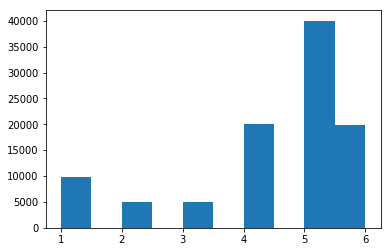

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time

t0=time.time()
rs=[np.random.choice(np.arange(1, 7), p=[0.1, 0.05, 0.05, 0.2, 0.4, 0.2]) for i in range(100000)]
print(time.time()-t0)
plt.hist(rs)
plt.show()

In [9]:
_dh

['D:\\Data science\\2021\\section 2']

In [4]:
pdf=[0.1, 0.05, 0.05, 0.2, 0.4, 0.2]
cdf=np.cumsum(pdf)
cdf

array([0.1 , 0.15, 0.2 , 0.4 , 0.8 , 1.  ])

0.10199785232543945


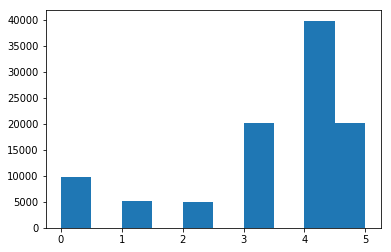

In [5]:
def empirical(cdf):
    r=random.random()
    i=0
    for x in cdf:
        if x>r: 
            #print(r, i)
            return i
        i+=1

t0=time.time()
rrs=[empirical(cdf) for i in range(100000)]
print(time.time()-t0)

plt.hist(rrs)
plt.show()

<h3>Random numger generation in Numpy</h3>

https://numpy.org/doc/1.21/reference/random/index.html?highlight=random#module-numpy.random

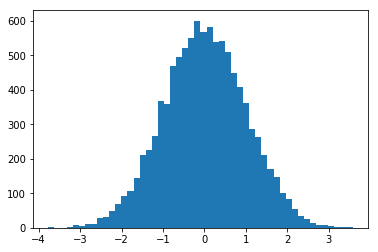

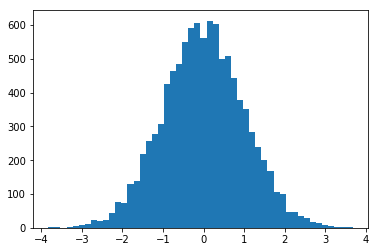

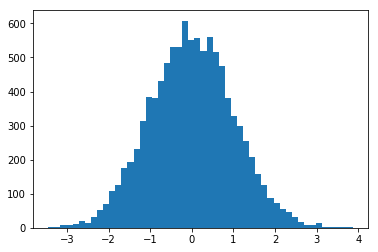

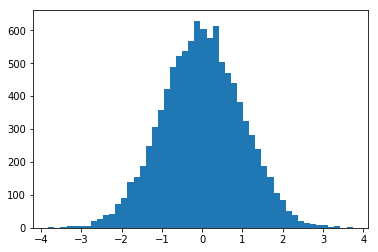

In [8]:
from numpy.random import default_rng
rng = default_rng()
vals = rng.standard_normal(10000)
plt.hist(vals, bins=50)
plt.show()

more_vals = rng.standard_normal(10000)
plt.hist(more_vals, bins=50)
plt.show()

# instead of this (legacy version)
from numpy import random
vals = random.standard_normal(10000)
plt.hist(vals, bins=50)
plt.show()

more_vals = random.standard_normal(10000)
plt.hist(more_vals, bins=50)
plt.show()


<h1>Bootstrapping</h1>

In [5]:
import time
from mylib import *
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


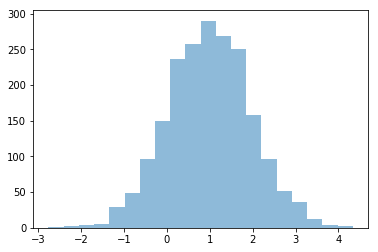

In [2]:
# polling from a normal distribution many times 
ndata=2000
data=np.random.normal(1,1,ndata)
plt.hist(data, alpha=0.5, bins=20)
plt.show()

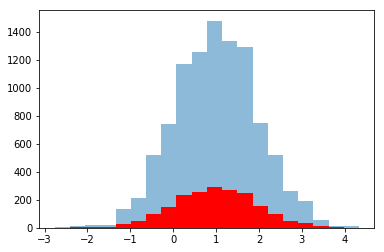

In [3]:
# by resampling the same data (BOOTSTRAPPING!) repeatlt, the distribution is very much like the original sample
sim_idx=np.random.randint(0,ndata, size=10000)
sim_data=data[sim_idx]
## but the plt.hist is based on the count, can compare two distributions of different size
plt.hist(sim_data, bins=20, alpha=0.5)
plt.hist(data, bins=20, color='red')
plt.show()

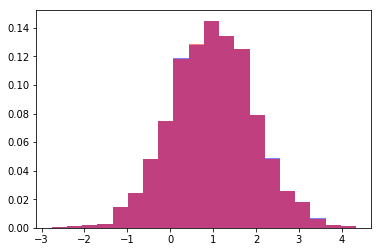

In [4]:
# define histgram with percentage, so two distribution can be shown in one chart
def pltHistPernt(x, color='blue'):
    plt.hist(x, bins=20, alpha=0.5, color=color, weights=np.ones(len(x)) / len(x))

sim_idx=np.random.randint(0,ndata, size=int(ndata*1000))
sim_data=data[sim_idx]

pltHistPernt(sim_data, 'blue')
pltHistPernt(data, 'red')

Above experiment should not be suprise, but it is the funadation of bootstrapping method. 

<h2>Confidence Interval of Statistics</h2>

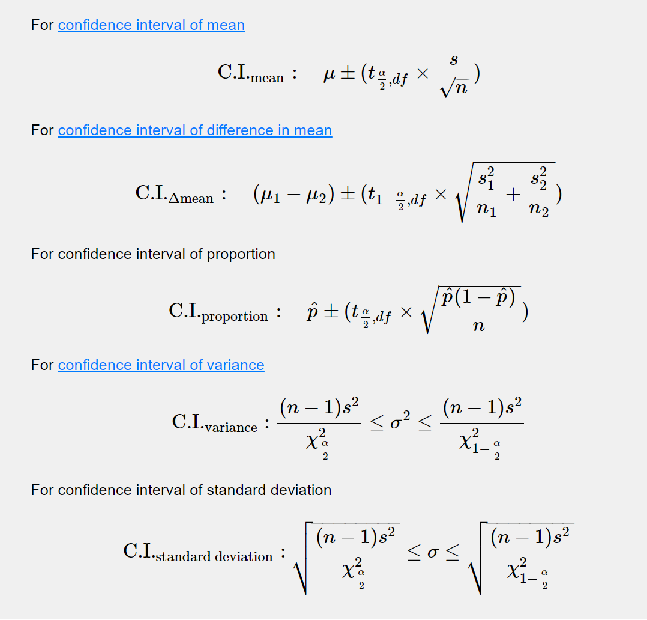

The needs for getting confidence interval 
<ul>
<li>Confidence interval quantifies uncertainty of statistical estimation
<li>Confidence interval is the basis of parametric hypothesis tests
<li>confidence interval for many other statistics cannot be analytically solved, simply because there are no formulas for them. If the statistic of your interest does not have an analytical solution for its confidence interval, or you simply don't know it, numerical methods like boostrapping can be a good alternative (and its powerful).
</ul>

Facts about boostrappinhg
<ul>
<li>Always use t-score instead of z-score
<li>Parametric methods suffer loss in accuracy under non-normality
<li>95% C.I. does not mean 95% of the sample data lie within the interval.
<li>Bigger sample size gives narrower confidence intervals
<li>Means are not always equivalent to central tendency
</ul>

(71.33139551903422, 75.19543685256606)


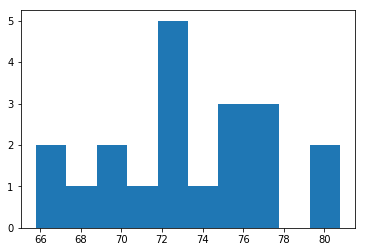

(73.99516629418433, 74.36800696994068)


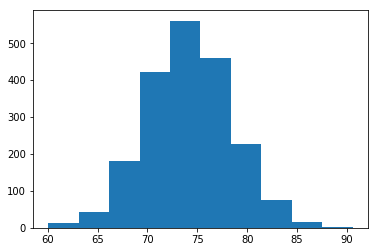

In [6]:
# using the analytical approach 
np.random.seed(42)

def confidenceLevelOfMean(arr):
    alpha = 0.05                       # significance level = 5%
    df = len(arr) - 1                  # degress of freedom = 20
    t = stats.t.ppf(1 - alpha/2, df)   # t-critical value for 95% CI = 2.093
    s = np.std(arr, ddof=1)            # sample standard deviation = 2.502
    n = len(arr)

    lower = np.mean(arr) - (t * s / np.sqrt(n))
    upper = np.mean(arr) + (t * s / np.sqrt(n))
    return lower, upper

arr = np.random.normal(loc=74, scale=4.3, size=20)  
print(confidenceLevelOfMean(arr))
plt.hist(arr)
plt.show()

pop = np.random.normal(loc=74, scale=4.3, size=2000)  
print(confidenceLevelOfMean(pop))
plt.hist(pop)
plt.show()

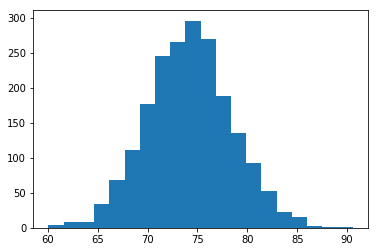

In [195]:
_=plt.hist(pop, bins=20)

small sample (71.56025458503876, 75.10050244790565)


Text(0.5, 1.0, 'distribution of mean() over small sample')

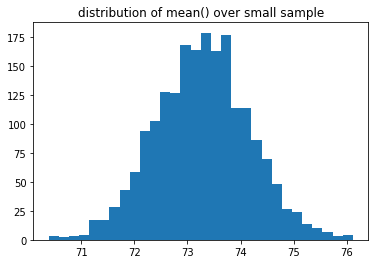

In [8]:
import numpy as np

def bootstrap(data, func, nRepeats=2000):
    array = np.array(data, dtype=np.float64)
    n = len(array)
    sample_result = [func(array[ np.random.randint(0, n, size=n)]) for i in range(nRepeats)]
    
    return sample_result

def getTails(distribution, lvl=0.95):
    length=len(distribution)
    k1 = int(length * (1-lvl) / 2)
    distribution_sorted = sorted(distribution)
    lower = distribution_sorted[k1]
    higher = distribution_sorted[length-k1]

    return lower, higher

def boost_conf(data, func, nRepeats=2000, clvl=0.95):
    result_dist=bootstrap(data, func, nRepeats)
    return getTails(result_dist, clvl), result_dist

boostrapped=bootstrap(arr, np.mean, 2000)
result1=getTails(boostrapped, 0.95)
print('small sample', result1)
_=plt.hist(boostrapped, bins=30)
plt.title('distribution of mean() over small sample')


population (74.00564942291454, 74.36718272591676)


Text(0.5, 1.0, 'distribution of mean() over population')

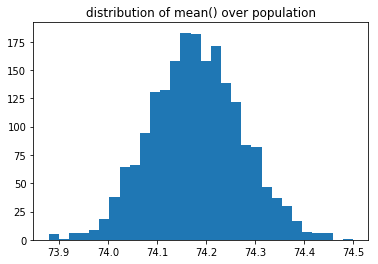

In [9]:
result2= boost_conf(pop, np.mean, 2000, 0.95)
print('population', result2[0])
_=plt.hist(result2[1], bins=30)
plt.title('distribution of mean() over population')

<h2> $ {\chi}^2 $ distribution </h2>

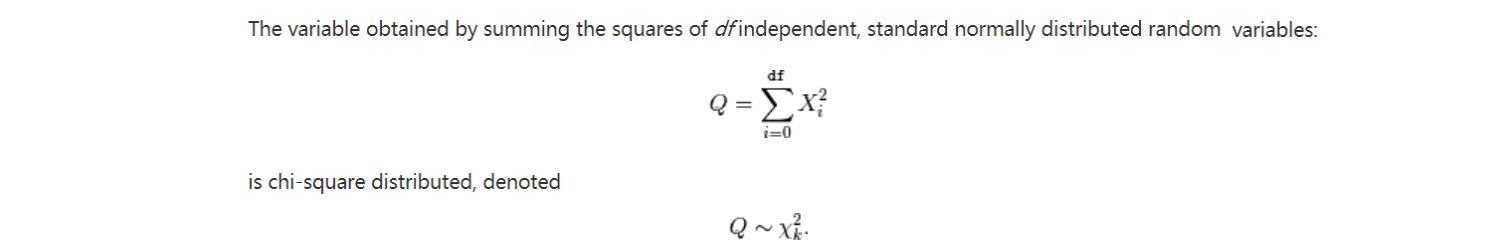

In [11]:
# using analytic approach from Scipy
df = 20
right_tail = stats.chi2.ppf(1 - 0.025, df)
left_tail = stats.chi2.ppf(1 - 0.975, df)
print('df='+str(df), left_tail, right_tail)

df = 2000
right_tail = stats.chi2.ppf(1 - 0.025, df)
left_tail = stats.chi2.ppf(1 - 0.975, df)
print('df='+str(df), left_tail, right_tail)


df=20 9.590777392264867 34.16960690283833
df=2000 1877.9460368153905 2125.8423024497756


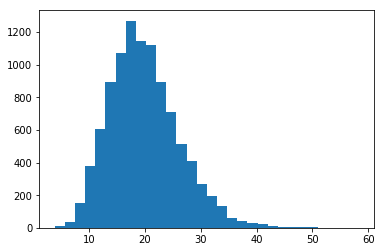

(9.733932222202732, 33.758879932770775)


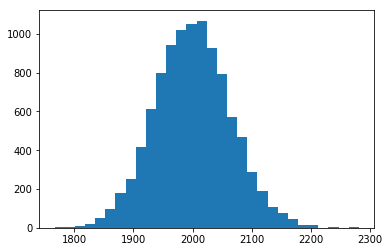

(1878.419383551226, 2127.567719021224)


In [330]:
# the tails can be obtained by large number of drawings
chi2_20=np.random.chisquare(20, size=10000)
_=plt.hist(chi2_20, bins=30)
plt.show()
print(getTails(chi2_20))

chi2_2000=np.random.chisquare(2000, size=10000)
_=plt.hist(chi2_2000, bins=30)
plt.show()
print(getTails(chi2_2000))


<h3>Bootstrapping of the confidence level of $ {\chi}^2 $ </h3>

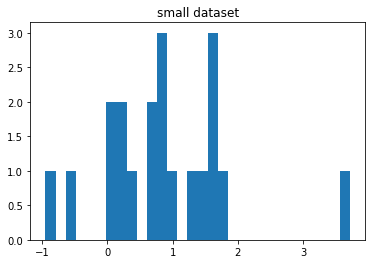

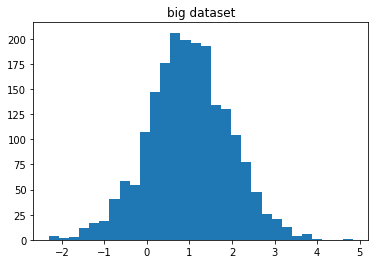

In [12]:
# Now, we are going to using boostrapping method to do the same
small=np.random.normal(1,1, 20) 
_=plt.hist(small ,bins=30)
plt.title('small dataset')
plt.show()

big=np.random.normal(1,1,2000) 
plt.title('big dataset')
_=plt.hist(big ,bins=30)
plt.show()

small sample (6.301086051138289, 35.50003504854772)


Text(0.5, 1.0, 'boostrapped chi-2 using small dataset')

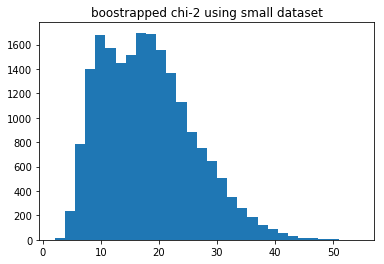

In [13]:
# chi-square statistics is defined  
def chi2(data):
    data-=np.mean(data)
    return data.dot(data)  

result_chi1=boost_conf(small, chi2, 20000)
print('small sample', result_chi1[0])
_=plt.hist(result_chi1[1],bins=30)
plt.title('boostrapped chi-2 using small dataset')

bug (1739.0995566690094, 1978.6619573217506)


Text(0.5, 1.0, 'boostrapped chi-2 using big dataset')

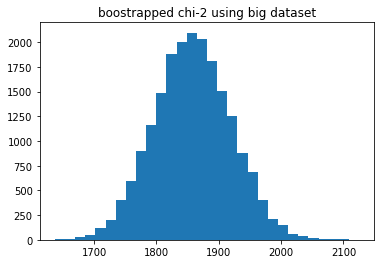

In [14]:
result_chi2=boost_conf(big, chi2, 20000)
print('bug', result_chi2[0])
_=plt.hist(result_chi2[1],bins=30)
plt.title('boostrapped chi-2 using big dataset')

<h3>Boostrapping</h3>

The above example shows the power of bootstrapping. Bootstrapping allows you to avoid these practical concerns, such as the lack of formulas to compute the confidence interval of covariance and median. In regression analysis, even though the regression coefficient has its own formula for its confidence interval, but the formulas get really messy in cases of multi-linear or non-linear regression. Wouldn't it be nice if there's a "magic" that saves you from all the math you have to worry about?

User of boostrapping may wonder why resampling the same sample over and over gives good results? If we are resampling from our sample, how is it that we are learning something about the population rather than only about the sample? The idea comes from the assumption that the sample is a reasonable representation of its underlying population — the population is to the sample as the sample is to the bootstrap samples.

<h3>Assumptions and Limitations of Bootstrap</h3>

Bootstrapping is great because it saves you from the normality assumption of distributions and all the math you have to know to construct confidence intervals. However, just like many other techniques, bootstrap has its own caveats. While bootstrap is distribution-free, it is not assumption-free. The assumptions are listed in this section.

Please note that there is a humongous variety of the bootstrap procedures, each addressing the particular quirk in either the statistic, the sample size, the dependence, or whatever an issue with the bootstrap could be. I am not introducing all of them here as the in-depth technical discussion of bootstrap needs another devoted post, but I still want you to know some of the critical assumptions; I want you to know what you don't know, so that you can google later to learn in-depth.

<ul>
    <li>A sample is a good representation of its underlying population.  If the original sample is biased, the resulting bootstrap samples will also be biased. However, this is a problem of not just bootstrapping, but all statistical techniques.
       <li>Insufficient samples make the bootstrap C.I. to be narrower than the analytical C.I. If you have too small sample, by a high chance it is not diverse enough to represent all (reasonably) possible aspects of its population. Therefore, it is not a good representation of its population. Second, small sample size makes its bootstrap C.I. to be narrower than the analytical C.I.
   <li>Bootstrap fails to estimate extreme quantiles. This has the root on the roandom number generating. For example, the range of 100 million drawing from normal (0,1) distribution is within [-5.421120914993705, 5.496999875144767]
       
   <li>Bootstrap iteration should be sufficient to reproduce consistent C.I's.
   <li>Samples are independent and identically distributed. This may not fit the time series or any drawing with 'trend'.
   <li>Bootstrapping continuous data is a bit tricky
   <li>Bootstrap is not robust in heavy-tailed distributions